In [2]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import scipy as sp
from scipy import sparse

import matplotlib.pyplot as plt
import matplotlib

import pickle
import time
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [3]:
torch.__version__

'2.1.1+cu121'

In [4]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
)
from text_embeddings_src.metrics import knn_accuracy

In [5]:
import jupyter_black

jupyter_black.load(line_length=79)

In [6]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [9]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [10]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [11]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers -p openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-06-12 14:25:07CEST

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

openTSNE: 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

matplotlib         : 3.8.2
memory_profiler    : 0.61.0
pandas             : 2.1.3
distro             : 1.8.0
jupyter_black      : 0.3.4
text_embeddings_src: 0.0.0
scipy              : 1.11.4
numpy              : 1.26.2
torch              : 2.1.1

Watermark: 2.4.3

Ubuntu 22.04.3 LTS


# Import

## ICLR

In [28]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 312 ms, sys: 97.9 ms, total: 410 ms
Wall time: 786 ms


In [29]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [30]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [31]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

In [32]:
# sanity check
print(len(np.unique(labels_iclr)))
labels_iclr

46


array(['unlabeled', 'unlabeled', 'optimization', ..., 'unlabeled',
       'unlabeled', 'federated learning'], dtype='<U34')

## Exploration

In [14]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    # "sentence-transformers/all-mpnet-base-v2",
    # "allenai/scibert_scivocab_uncased",
    # "allenai/specter",
    # "malteos/scincl",
]

In [15]:
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set the random seed for NumPy
np.random.seed(seed)

# Set the random seed
random.seed(seed)

In [16]:
# initialize
i = 1

# random_state = random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


In [17]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embeddings.word_embeddings.weight: True
embeddings.position_embeddings.weight: True
embeddings.LayerNorm.weight: True
embeddings.LayerNorm.bias: True
encoder.layer.0.attention.attn.q.weight: True
encoder.layer.0.attention.attn.q.bias: True
encoder.layer.0.attention.attn.k.weight: True
encoder.layer.0.attention.attn.k.bias: True
encoder.layer.0.attention.attn.v.weight: True
encoder.layer.0.attention.attn.v.bias: True
encoder.layer.0.attention.attn.o.weight: True
encoder.layer.0.attention.attn.o.bias: True
encoder.layer.0.attention.LayerNorm.weight: True
encoder.layer.0.attention.LayerNorm.bias: True
encoder.layer.0.intermediate.dense.weight: True
encoder.layer.0.intermediate.dense.bias: True
encoder.layer.0.output.dense.weight: True
encoder.layer.0.output.dense.bias: True
encoder.layer.0.output.LayerNorm.weight: True
encoder.layer.0.output.LayerNorm.bias: True
encoder.layer.1.attention.attn.q.weight: True
encoder.layer.1.attention.attn.q.bias: True
encoder.layer.1.attention.attn.k.weigh

### exploration output

In [18]:
test_text = ["Hi my name is Rita."]

In [19]:
# preprocess the input
inputs = tokenizer(
    test_text,
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=512,
).to(device)

In [20]:
inputs

{'input_ids': tensor([[    0,  7636,  2030,  2175,  2007, 11624,  1016,     2]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [21]:
model.to(device)

MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [36]:
outputs = model(**inputs, output_hidden_states=True)

In [38]:
outputs

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.1944,  0.2234, -0.0105,  ...,  0.1301, -0.0548,  0.0220],
         [-0.0627, -0.2211, -0.0483,  ...,  0.0552, -0.0270, -0.0104],
         [-0.1352,  0.0082,  0.0685,  ..., -0.0541,  0.0621,  0.0774],
         ...,
         [ 0.0301,  0.4014,  0.0188,  ...,  0.1003, -0.0244, -0.0517],
         [ 0.0797,  0.0526,  0.0305,  ...,  0.0518, -0.1234, -0.0463],
         [ 0.0103,  0.4551,  0.0095,  ...,  0.0741, -0.1618,  0.0528]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-9.7415e-02, -1.1584e-02,  1.0352e-01, -1.3844e-01, -5.4417e-02,
         -1.2373e-01,  5.3764e-03, -4.1767e-02, -5.9837e-02,  1.1085e-01,
          1.2878e-01,  6.5861e-02, -1.0881e-02, -1.1146e-01, -6.7798e-03,
          7.4034e-02, -3.2392e-02,  3.4521e-02,  7.2835e-03, -7.6494e-02,
          1.3756e-01,  5.3989e-02,  4.7872e-02, -3.0256e-02,  2.7664e-03,
         -7.1658e-02,  9.9448e-02, -5.2579e-02,  8.0335e-02, -1.4681

In [35]:
# (one for the output of the embeddings, if the model has an embedding layer, + one for the output of each layer)
for i, hid in enumerate(
    model(**inputs, output_hidden_states=True).hidden_states
):
    print(i)
hid.shape  # [1].shape

0
1
2
3
4
5
6
7
8
9
10
11
12


torch.Size([1, 8, 768])

In [41]:
outputs.hidden_states[-1] == outputs.last_hidden_state

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]], device='cuda:0')

In [47]:
outputs.last_hidden_state.shape

torch.Size([1, 8, 768])

# Guillotine

In [34]:
# import mean pooling and all that
from text_embeddings_src.embeddings import mean_pooling, sep_pooling
import datasets
import torch
from tqdm.notebook import tqdm


@torch.no_grad()
def generate_embeddings_hidden_state(
    layer_number,
    abstracts,
    tokenizer,
    model,
    device,
    batch_size=2048,
    return_seventh=False,
):
    """Generate embeddings using BERT-based model.
    Code from Luca Schmidt.

    Parameters
    ----------
    abstracts : list, this has to be a list not sure if array works but pandas do not work
        Abstract texts.
    tokenizer : transformers.models.bert.tokenization_bert_fast.BertTokenizerFast
        Tokenizer.
    model : transformers.models.bert.modeling_bert.BertModel
        BERT-based model.
    device : str, {"cuda", "cpu"}
        "cuda" if torch.cuda.is_available() else "cpu".

    Returns
    -------
    embedding_cls : ndarray
        [CLS] tokens of the abstracts.
    embedding_sep : ndarray
        [SEP] tokens of the abstracts.
    embedding_av : ndarray
        Average of tokens of the abstracts.
    """
    # preprocess the input
    inputs = tokenizer(
        abstracts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512,
    ).to(device)

    dataset = datasets.Dataset.from_dict(inputs)
    dataset.set_format(type="torch", output_all_columns=True)
    loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, num_workers=10
    )

    # new inference
    # model.to(device)

    embedding_av = []
    embedding_sep = []
    embedding_cls = []
    embedding_7th = []

    with torch.no_grad():
        model.eval()
        for batch in tqdm(loader):
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch, output_hidden_states=True)
            token_embeds = out.hidden_states[layer_number]
            av = mean_pooling(token_embeds, batch["attention_mask"])
            sep = sep_pooling(token_embeds, batch["attention_mask"])
            cls = token_embeds[:, 0, :]  # .numpy()
            embedding_av.append(av.detach().cpu().numpy())
            embedding_sep.append(sep.detach().cpu().numpy())
            embedding_cls.append(cls.detach().cpu().numpy())
            if return_seventh == True:
                seventh = token_embeds[:, 7, :]
                embedding_7th.append(seventh.detach().cpu().numpy())

    embedding_av = np.vstack(embedding_av)
    embedding_sep = np.vstack(embedding_sep)
    embedding_cls = np.vstack(embedding_cls)

    if return_seventh == True:
        embedding_7th = np.vstack(embedding_7th)

    return (
        (embedding_cls, embedding_sep, embedding_av, embedding_7th)
        if return_seventh == True
        else (embedding_cls, embedding_sep, embedding_av)
    )

## MPNet

### For trained model

In [42]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [43]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    #     "sentence-transformers/all-mpnet-base-v2",
    #     "allenai/scibert_scivocab_uncased",
    #     "allenai/specter",
    #     "malteos/scincl",
]

In [44]:
%%time

i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

# data
training_dataset = MultOverlappingSentencesPairDataset(
    iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
)

gen = torch.Generator()
gen.manual_seed(seed)
training_loader = torch.utils.data.DataLoader(
    training_dataset, batch_size=64, shuffle=True, generator=gen
)
print("Training loader length: ", len(training_loader))



Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
Training loader length:  368
CPU times: user 1min 15s, sys: 26.9 s, total: 1min 42s
Wall time: 14.2 s


In [45]:
##  train_loop_batches_eval
loader = training_loader
titles_abstracts_together = iclr2024.abstract.to_list()
# tokenizer =
label_mask = labels_iclr != "unlabeled"
labels_acc = labels_iclr[labels_iclr != "unlabeled"]
optimized_rep = "av"
n_epochs = 1
lr = 2e-5
eval_metric = "knn"
return_seventh = False

model.to(device)

# define layers to be used in multiple-negatives-ranking
cos_sim = torch.nn.CosineSimilarity()
loss_func = torch.nn.CrossEntropyLoss()
scale = 20.0  # we multiply similarity score by this scale value
# move layers to device
cos_sim.to(device)
loss_func.to(device)

# initialize Adam optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# setup warmup for first ~10% of steps
total_steps = len(loader) * n_epochs
warmup_steps = int(0.1 * len(loader))
scheduler = get_linear_schedule_with_warmup(
    optim,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)

losses = np.empty((n_epochs, len(loader)))

for epoch in range(n_epochs):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for i_batch, batch in enumerate(loop):
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        anchor_ids = batch[0][0].to(device)
        anchor_mask = batch[0][1].to(device)
        pos_ids = batch[1][0].to(device)
        pos_mask = batch[1][1].to(device)
        # extract token embeddings from BERT
        a = model(anchor_ids, attention_mask=anchor_mask)[
            0
        ]  # all token embeddings
        p = model(pos_ids, attention_mask=pos_mask)[0]

        # get the mean pooled vectors
        if optimized_rep == "av":
            a = mean_pool(a, anchor_mask)
            p = mean_pool(p, pos_mask)

        elif optimized_rep == "cls":
            a = cls_pool(a, anchor_mask)
            p = cls_pool(p, pos_mask)

        elif optimized_rep == "sep":
            a = sep_pool(a, anchor_mask)
            p = sep_pool(p, pos_mask)

        elif optimized_rep == "7th":
            a = seventh_pool(a, anchor_mask)
            p = seventh_pool(p, pos_mask)

        # calculate the cosine similarities
        scores = torch.stack(
            [cos_sim(a_i.reshape(1, a_i.shape[0]), p) for a_i in a]
        )
        # get label(s) - we could define this before if confident
        # of consistent batch sizes
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )
        # and now calculate the loss
        loss = loss_func(
            scores * scale, labels
        )  # Nik does not know what the labels nor the scale are
        losses[epoch, i_batch] = loss.item()

        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())

  0%|          | 0/368 [00:00<?, ?it/s]

In [53]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.50307692 0.03       0.05230769]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.46153846 0.31076923 0.10846154]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.42692308 0.23076923 0.11230769]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.44       0.23923077 0.10692308]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41461538 0.24153846 0.07846154]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40307692 0.17846154 0.09230769]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40076923 0.14615385 0.13384615]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.38307692 0.14538462 0.14230769]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41076923 0.12846154 0.15      ]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.43846154 0.17692308 0.15153846]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.48230769 0.29846154 0.27769231]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.54230769 0.39       0.34538462]
-----------------------
layer number 12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.58692308 0.50846154 0.54384615]
-----------------------
CPU times: user 30min 45s, sys: 43min 15s, total: 1h 14min 1s
Wall time: 45min 48s


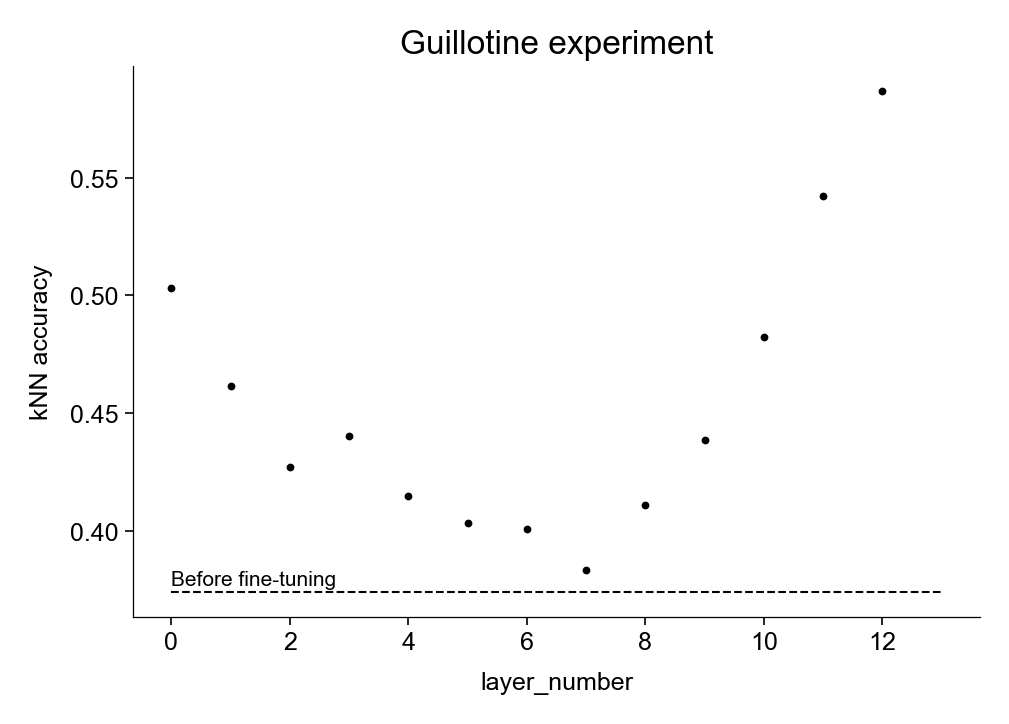

In [24]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    ax.scatter(layer_number, knn_acc[0], c="k", s=3, marker=".")
# ax.hlines(0.374, 0, 12, color="r")
ax.hlines(0.374, 0, 13, color="k", linestyle="--")
ax.text(
    0,
    0.374 + 0.001,
    f"Before fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_mpnet_v1.png")

In [18]:
print(knn_acc)

[0.58692308 0.50846154 0.54384615]


### For untrained model

In [37]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [38]:
model_names = [
    "BERT",
    "MPNet",
    # "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
    #     "sentence-transformers/all-mpnet-base-v2",
    #     "allenai/scibert_scivocab_uncased",
    #     "allenai/specter",
    #     "malteos/scincl",
]

In [39]:
%%time

i = 1
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model.to(device)

# # data
# training_dataset = MultOverlappingSentencesPairDataset(
#     iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
# )

# gen = torch.Generator()
# gen.manual_seed(seed)
# training_loader = torch.utils.data.DataLoader(
#     training_dataset, batch_size=64, shuffle=True, generator=gen
# )
# print("Training loader length: ", len(training_loader))



Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base
CPU times: user 2.09 s, sys: 1.19 s, total: 3.28 s
Wall time: 2.28 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [41]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.49923077 0.03       0.05230769]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.44846154 0.30230769 0.10846154]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40615385 0.20461538 0.11230769]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.40384615 0.23923077 0.10923077]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.37692308 0.23384615 0.08538462]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35461538 0.14       0.09538462]
-----------------------
layer number 6


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36461538 0.13461538 0.14538462]
-----------------------
layer number 7


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.33538462 0.13384615 0.11230769]
-----------------------
layer number 8


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.33692308 0.11384615 0.11461538]
-----------------------
layer number 9


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.35076923 0.12923077 0.13230769]
-----------------------
layer number 10


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.36846154 0.16923077 0.16692308]
-----------------------
layer number 11


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.41384615 0.30307692 0.23076923]
-----------------------
layer number 12


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.37384615 0.31769231 0.36307692]
-----------------------
CPU times: user 31min 44s, sys: 43min 6s, total: 1h 14min 51s
Wall time: 45min 35s


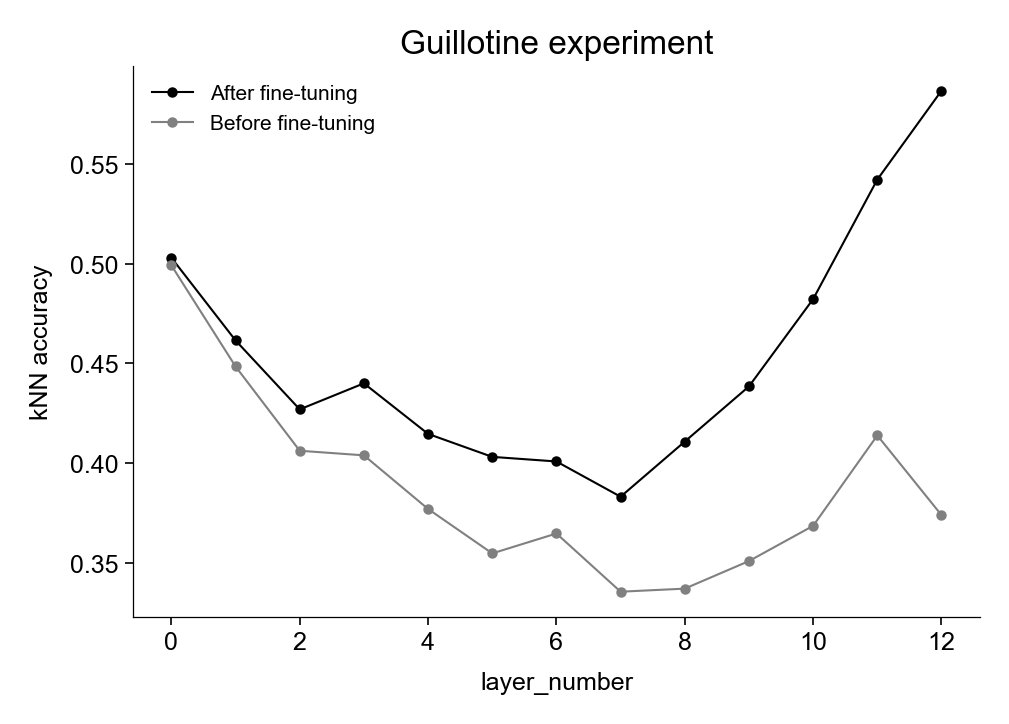

In [45]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "MPNet"
knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before = np.load(
        variables_path / saving_path / saving_name,
    )
    # print(layer_number, knn_acc)

    knn_acc_after_all.append(knn_acc_after[0])
    knn_acc_before_all.append(knn_acc_before[0])

ax.plot(
    np.arange(13),
    knn_acc_after_all,
    c="k",
    ms=3,
    marker=".",
    label="After fine-tuning",
)
ax.plot(
    np.arange(13),
    knn_acc_before_all,
    c="grey",
    ms=3,
    marker=".",
    label="Before fine-tuning",
)
ax.legend()
# ax.hlines(0.374, 0, 12, color="r")
# ax.hlines(0.374, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.374 + 0.001,
#     f"Before fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
# ax.hlines(0.589, 0, 13, color="k", linestyle="--")
# ax.text(
#     0,
#     0.589 + 0.001,
#     f"After fine-tuning",
#     fontsize=5,
#     va="bottom",
#     ha="left",
# )
ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_mpnet_v3.png")

## SBERT

In [14]:
import torch

# from sklearn.model_selection import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

# from transformers import AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from text_embeddings_src.model_stuff import mean_pool

In [15]:
model_names = [
    # "BERT",
    # "MPNet",
    "SBERT",
    # "SciBERT",
    # "SPECTER",
    # "SciNCL",
]


model_paths = [
    # "bert-base-uncased",
    # "microsoft/mpnet-base",
    "sentence-transformers/all-mpnet-base-v2",
    #     "allenai/scibert_scivocab_uncased",
    #     "allenai/specter",
    #     "malteos/scincl",
]

In [16]:
%%time

i = 0
model_name = model_names[i]

## fix random seeds
seed = 42
# Set the random seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)
# Set the random seed for NumPy
np.random.seed(seed)
# Set the random seed
random.seed(seed)

# set up model
print("Model: ", model_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device: {}".format(device))

tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
model = AutoModel.from_pretrained(model_paths[i])
print(model_paths[i])

model.to(device)

# # data
# training_dataset = MultOverlappingSentencesPairDataset(
#     iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
# )

# gen = torch.Generator()
# gen.manual_seed(seed)
# training_loader = torch.utils.data.DataLoader(
#     training_dataset, batch_size=64, shuffle=True, generator=gen
# )
# print("Training loader length: ", len(training_loader))



Model:  SBERT
Running on device: cuda


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence-transformers/all-mpnet-base-v2
CPU times: user 12.5 s, sys: 4.06 s, total: 16.6 s
Wall time: 15.1 s


MPNetModel(
  (embeddings): MPNetEmbeddings(
    (word_embeddings): Embedding(30527, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): MPNetEncoder(
    (layer): ModuleList(
      (0-11): 12 x MPNetLayer(
        (attention): MPNetAttention(
          (attn): MPNetSelfAttention(
            (q): Linear(in_features=768, out_features=768, bias=True)
            (k): Linear(in_features=768, out_features=768, bias=True)
            (v): Linear(in_features=768, out_features=768, bias=True)
            (o): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (intermediate): MPNetIntermediate(
          (dense): Linear(in_

In [35]:
%%time
for layer_number in np.arange(13):
    print("layer number", layer_number)
    (
        embedding_cls,
        embedding_sep,
        embedding_av,
    ) = generate_embeddings_hidden_state(
        layer_number,
        iclr2024.abstract.to_list(),  # CHANGE THIS
        tokenizer,
        model,
        device,
        batch_size=256,
    )

    knn_acc = knn_accuracy(
        [
            embedding_av[labels_iclr != "unlabeled"],
            embedding_cls[labels_iclr != "unlabeled"],
            embedding_sep[labels_iclr != "unlabeled"],
        ],
        labels_iclr[labels_iclr != "unlabeled"],
    )

    # save
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    (variables_path / saving_path).mkdir(exist_ok=True)

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}"
    np.save(
        variables_path / saving_path / saving_name,
        knn_acc,
    )
    print(knn_acc)
    print("-----------------------")

    # save

layer number 0


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.52       0.03       0.05153846]
-----------------------
layer number 1


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.49615385 0.32       0.13230769]
-----------------------
layer number 2


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.47230769 0.24615385 0.14846154]
-----------------------
layer number 3


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.46461538 0.35538462 0.13230769]
-----------------------
layer number 4


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[0.46153846 0.35769231 0.12076923]
-----------------------
layer number 5


  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [ ]:
f"guillotine_experiment_{model_name.lower()}_v1.png"

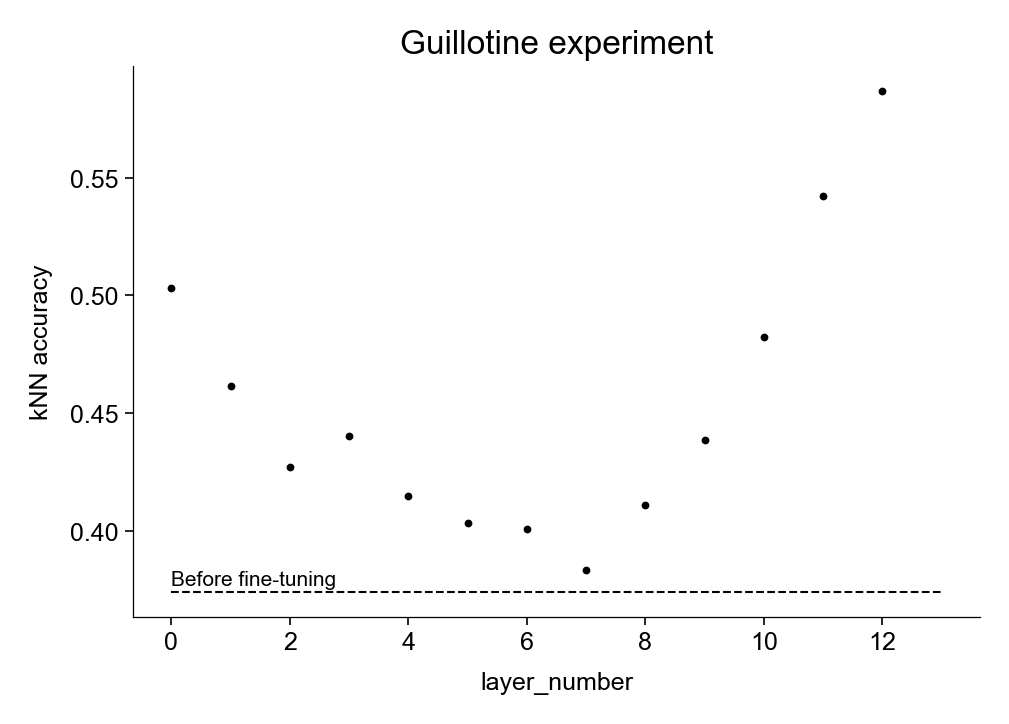

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")

model_name = "SBERT"
for layer_number in np.arange(13):
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )
    
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc = np.load(
        variables_path / saving_path / saving_name,
    )

    knn_acc_all.append(knn_acc[0])

ax.plot(
    np.arange(13),
    knn_acc_all,
    c="k",
    ms=3,
    marker=".",
)

# load before and after training value
saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)

losses = np.load(variables_path / saving_path / "losses_run1.npy")
knn_accuracies_after = np.load(
    variables_path / saving_path / "knn_accuracies_run1.npy"
)

saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
knn_accuracies_before = np.load(
    variables_path / "updated_dataset" / saving_name_2
)
ax.hlines(knn_accuracies_before[0], 0, 13, color="k", linestyle="--")
ax.text(
    0,
    knn_accuracies_before[0] + 0.001,
    f"Before fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)
ax.hlines(knn_accuracies_after[0,0], 0, 13, color="k", linestyle="--")
ax.text(
    0,
    knn_accuracies_after[0,0] + 0.001,
    f"After fine-tuning",
    fontsize=5,
    va="bottom",
    ha="left",
)

ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / f"guillotine_experiment_{model_name.lower()}_v1.png")

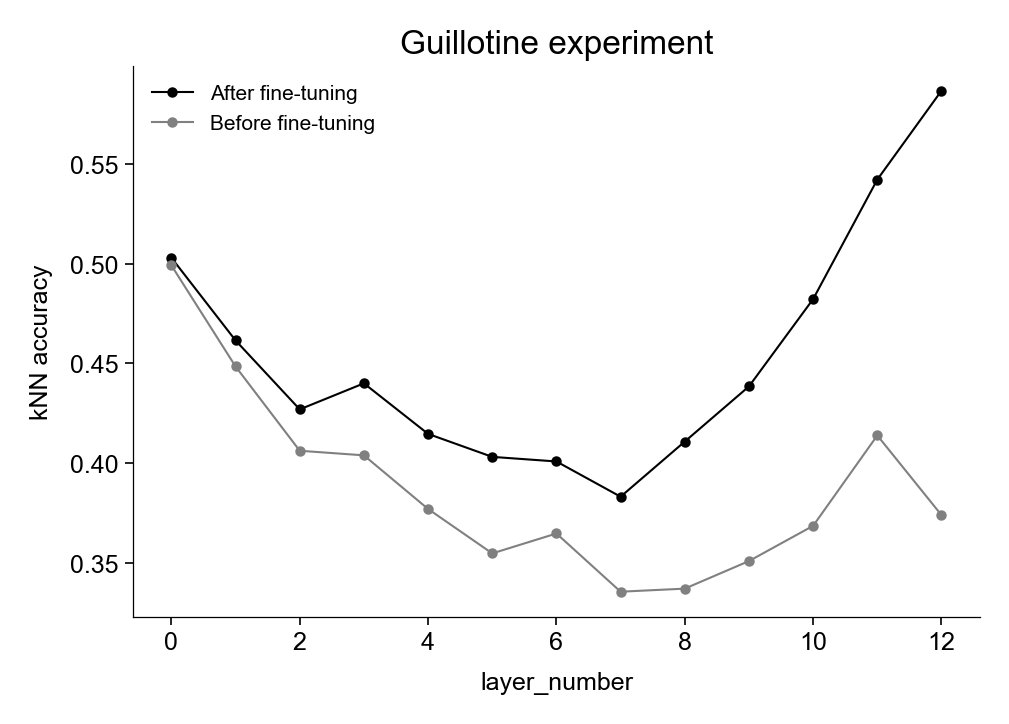

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(3.25, 2.3), dpi=300, layout="constrained")


knn_acc_after_all = []
knn_acc_before_all = []
for layer_number in np.arange(13):
    # load MPNet
    model_name = "MPNet"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_trained_av_after_layer_{layer_number}.npy"
    knn_acc_after_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_mpnet = np.load(
        variables_path / saving_path / saving_name,
    )
    # load SBERT
    model_name = "SBERT"
    saving_path = (
        Path("embeddings_" + model_name.lower())
        / Path("updated_dataset")
        / Path("guillotine_experiment")
    )

    saving_name = f"knn_accuracies_untrained_av_after_layer_{layer_number}.npy"
    knn_acc_before_sbert = np.load(
        variables_path / saving_path / saving_name,
    )

    # concatenate
    knn_acc_after_all_mpnet.append(knn_acc_after_mpnet[0])
    knn_acc_before_all_mpnet.append(knn_acc_before_mpnet[0])
    knn_acc_before_all_sbert.append(knn_acc_before_sbert[0])

ax.plot(
    np.arange(13),
    knn_acc_after_all_mpnet,
    c="k",
    ms=3,
    marker=".",
    label=" MPNet (after)",
)
ax.plot(
    np.arange(13),
    knn_acc_before_all_mpnet,
    c="grey",
    ms=3,
    marker=".",
    label="MPNet (before)",
)

ax.plot(
    np.arange(13),
    knn_acc_before_all_sbert,
    c="tab:green",
    ms=3,
    marker=".",
    label="SBERT (before)",
)
ax.legend()

ax.set_xlabel("layer_number")
ax.set_ylabel("kNN accuracy")
ax.set_title("Guillotine experiment")
fig.savefig(figures_path / "guillotine_experiment_several_models_v1.png")